# 1. 2022년 12월 기준 이후 데이터만 모으기

In [13]:
import pandas as pd

acad=pd.read_csv('data/02_journal_2020_2025.csv')
indu=pd.read_csv('data/04_article_2020_2025.csv')

In [14]:
acad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6780 entries, 0 to 6779
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         6780 non-null   object
 1   date          6780 non-null   int64 
 2   abstract      6780 non-null   object
 3   keywords      6780 non-null   object
 4   authors       6774 non-null   object
 5   affiliations  6780 non-null   object
dtypes: int64(1), object(5)
memory usage: 317.9+ KB


In [15]:
indu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14032 entries, 0 to 14031
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         14032 non-null  object 
 1   content       14032 non-null  object 
 2   date          14032 non-null  float64
 3   affiliations  14032 non-null  object 
 4   keywords      7604 non-null   object 
dtypes: float64(1), object(4)
memory usage: 548.3+ KB


In [16]:
# year 컬럼이 2023, 2024, 2025인 데이터만 선택
academia = acad[acad['date'].isin((2023, 2024, 2025))]
industry=indu[indu['date'].isin((2023, 2024, 2025))]

print(academia.value_counts(subset=['date']))
print(industry.value_counts(subset=['date']))

date
2024    1275
2023    1210
2025     724
Name: count, dtype: int64
date  
2024.0    4471
2023.0    3604
2025.0    3597
Name: count, dtype: int64


In [17]:
print(academia.value_counts(subset=['affiliations']))
print(industry.value_counts(subset=['affiliations']))

affiliations
HICSS           2098
ICIS             822
ISR              149
MISQ             140
Name: count, dtype: int64
affiliations       
techcrunch             2748
verge                  2328
the guardian           2128
BBC                    1363
Wall Street Journal     789
New York Times          751
Techcrunch              645
the_verge               531
CNN                     389
Name: count, dtype: int64


In [18]:
academia.to_csv('data/03_journal_2023_2025.csv', index=False, encoding='utf-8')
industry.to_csv('data/05_article_2023_2025.csv', index=False, encoding='utf-8')

# 2. 토픽모델링

In [6]:
import pandas as pd

# academia=pd.read_csv('data/03_journal_2023_2025.csv')
industry=pd.read_csv('data/05_article_2023_2025.csv')

In [7]:
import re
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel

def preprocess_text(text):
    """문자열 → 토큰화 → 불용어·특수문자 제거 → 표제어 추출."""
    if pd.isnull(text):
        return []
    if isinstance(text, list):
        text = ' '.join(text)
    if isinstance(text, str) and ('<' in text and '>' in text):
        text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"\$.*?\$", "", text)
    text = re.sub(r"\\\(.*?\\\)", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = text.lower()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]

    pos_tags = pos_tag(tokens)
    allowed = {'NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ'}
    filtered = [w for w, pos in pos_tags if pos in allowed]

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in filtered]

def run_lda_tfidf(
    df: pd.DataFrame,
    text_columns: list,
    num_topics: int = 20,
    no_below: int = 5,
    no_above: float = 0.5,
    keep_n: int = 100000,
    passes: int = 10,
    random_state: int = 42
):
    """
    df의 text_columns(예: ['title','content']) 합친 뒤 전처리 → TF-IDF 기반 LDA 수행.

    Returns:
      lda_model, dictionary, tfidf_model, corpus_tfidf
    """
    # 1. title, content 등 합치기 (null-safe)
    combined = df[text_columns].fillna('').agg(' '.join, axis=1)

    # 2. 전처리
    texts = combined.map(preprocess_text).tolist()

    # 3. 사전 생성 및 극단값 필터링
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(
        no_below=no_below,
        no_above=no_above,
        keep_n=keep_n
    )

    # 4. BOW 코퍼스 생성
    bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

    # 5. TF-IDF 모델링
    tfidf_model = TfidfModel(bow_corpus, id2word=dictionary)
    corpus_tfidf = tfidf_model[bow_corpus]

    # 6. LDA 학습
    lda_model = LdaModel(
        corpus=corpus_tfidf,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        random_state=random_state
    )

    return lda_model, dictionary, tfidf_model, corpus_tfidf



In [8]:
# industry 토픽모델링

# ─── 사용 예시 ─────────────────────────────────────────────────────────
lda_model_in, dictionary_in, tfidf_model_in, corpus_tfidf_in = run_lda_tfidf(
    industry,
    text_columns=['title', 'content'],
    num_topics=20,
    no_below=58,
    no_above=0.5,
    passes=10
)


In [9]:
for topic_id, terms in lda_model_in.print_topics(num_topics=20, num_words=10):
    print(f"토픽 #{topic_id}: {terms}")

토픽 #0: 0.014*"retention" + 0.000*"saas" + 0.000*"adobe" + 0.000*"accessed" + 0.000*"vcs" + 0.000*"asserts" + 0.000*"roadmap" + 0.000*"apis" + 0.000*"depending" + 0.000*"expression"
토픽 #1: 0.045*"musk" + 0.041*"grok" + 0.032*"trump" + 0.027*"xai" + 0.020*"summit" + 0.020*"api" + 0.018*"bill" + 0.017*"sunak" + 0.015*"president" + 0.013*"administration"
토픽 #2: 0.058*"board" + 0.046*"altman" + 0.043*"openai" + 0.034*"workspace" + 0.029*"musk" + 0.027*"murati" + 0.025*"profit" + 0.021*"brockman" + 0.019*"sutskever" + 0.018*"suleyman"
토픽 #3: 0.101*"adobe" + 0.050*"firefly" + 0.025*"photoshop" + 0.023*"quantum" + 0.009*"texture" + 0.007*"adventure" + 0.006*"object" + 0.004*"scaled" + 0.002*"dataset" + 0.001*"blur"
토픽 #4: 0.067*"hinton" + 0.041*"headset" + 0.027*"godfather" + 0.023*"lecun" + 0.021*"shortcut" + 0.019*"geoffrey" + 0.013*"yann" + 0.005*"prize" + 0.003*"intelligent" + 0.002*"architecture"
토픽 #5: 0.028*"intel" + 0.016*"core" + 0.014*"wallet" + 0.011*"configuration" + 0.010*"inch" +

In [12]:
# (2) Gensim 객체 저장
dictionary_in.save('data/industry_dictionary.dict')
tfidf_model_in.save('data/industry_tfidf.model')
lda_model_in.save('data/industry_lda.model')

# (3) 문서별 토픽 분포 계산 및 저장
topic_dist = []
for doc_id, doc_tfidf in enumerate(corpus_tfidf_in):
    doc_topics = dict(lda_model_in.get_document_topics(doc_tfidf, minimum_probability=0))
    doc_topics['doc_id'] = doc_id
    topic_dist.append(doc_topics)

topic_dist_df = pd.DataFrame(topic_dist)
cols = ['doc_id'] + [c for c in topic_dist_df.columns if c != 'doc_id']
topic_dist_df = topic_dist_df[cols]
topic_dist_df.to_csv('data/industry_topic_distribution.csv', index=False)

print("■ 모델 및 토픽 분포 저장 완료")

■ 모델 및 토픽 분포 저장 완료


In [5]:
# academia 토픽모델링
# ─── 사용 예시 ─────────────────────────────────────────────────────────
lda_model, dictionary, tfidf_model, corpus_tfidf = run_lda_tfidf(
    academia,
    text_columns=['title', 'abstract'],
    num_topics=20,
    no_below=16,
    no_above=0.5,
    passes=10
)


In [6]:
for topic_id, terms in lda_model.print_topics(num_topics=20, num_words=10):
    print(f"토픽 #{topic_id}: {terms}")

토픽 #0: 0.075*"xai" + 0.067*"aversion" + 0.041*"loyalty" + 0.034*"trade" + 0.010*"offs" + 0.004*"incorporated" + 0.003*"automate" + 0.002*"debate" + 0.002*"forecasting" + 0.001*"utility"
토픽 #1: 0.006*"data" + 0.006*"system" + 0.005*"model" + 0.005*"learning" + 0.005*"research" + 0.005*"design" + 0.004*"information" + 0.004*"technology" + 0.004*"work" + 0.004*"health"
토픽 #2: 0.022*"medium" + 0.015*"brand" + 0.015*"news" + 0.014*"disclosure" + 0.014*"influencers" + 0.013*"engagement" + 0.013*"user" + 0.011*"leadership" + 0.010*"intention" + 0.010*"privacy"
토픽 #3: 0.033*"robot" + 0.018*"metaverse" + 0.016*"nudge" + 0.015*"attack" + 0.013*"power" + 0.012*"grid" + 0.012*"prompt" + 0.010*"cyber" + 0.010*"confidence" + 0.009*"protection"
토픽 #4: 0.035*"personality" + 0.034*"woman" + 0.032*"trait" + 0.031*"gender" + 0.029*"disability" + 0.019*"message" + 0.018*"engaging" + 0.017*"week" + 0.017*"contributor" + 0.016*"hope"
토픽 #5: 0.085*"genai" + 0.042*"gai" + 0.039*"creativity" + 0.032*"delegatio

In [8]:
academia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         3209 non-null   object
 1   date          3209 non-null   int64 
 2   abstract      3209 non-null   object
 3   keywords      3209 non-null   object
 4   authors       3209 non-null   object
 5   affiliations  3209 non-null   object
dtypes: int64(1), object(5)
memory usage: 150.6+ KB


In [9]:
industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11672 entries, 0 to 11671
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         11672 non-null  object 
 1   content       11672 non-null  object 
 2   date          11672 non-null  float64
 3   affiliations  11672 non-null  object 
 4   keywords      6252 non-null   object 
dtypes: float64(1), object(4)
memory usage: 456.1+ KB


# 3. 키워드 기반 type 1,2,3 분류 방법 모색

In [10]:
import pandas as pd
df=pd.read_csv('data/03_journal_2023_2025.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         3209 non-null   object
 1   date          3209 non-null   int64 
 2   abstract      3209 non-null   object
 3   keywords      3209 non-null   object
 4   authors       3209 non-null   object
 5   affiliations  3209 non-null   object
dtypes: int64(1), object(5)
memory usage: 150.6+ KB


In [11]:
print(df['keywords'][:5])

0    digital x, IT x, digitalization, digitization,...
1    data protection regulation, government policy,...
2    personal health management, online healthcare ...
3    customer response prediction, voice chat, theo...
4    recommendation system, personalization, decoy ...
Name: keywords, dtype: object


In [12]:
import pandas as pd

# 1. 데이터 로드
input_path = 'data/03_journal_2023_2025.csv'
df = pd.read_csv(input_path, encoding='utf-8')

# 2. 컬럼 이름 소문자화
df.columns = df.columns.str.lower()

# 3. 타입별 키워드 리스트 정의 (업데이트)
design_terms = [
    "design", "algorithm", "model", "framework", "implementation",
    "design science", "it artifact", "computational model", "predictive analytics",
    "ablation study", "benchmarking", "case study", "simulation", "data quality",
    "fairness", "explainability", "transparency", "knowledge graph", "auto-ml"
]

econ_terms = [
    "causal", "treatment", "effect", "econometric", "regression", "instrument",
    "causal inference", "confounders", "heterogeneous effects", "personalized intervention",
    "structural model", "point process", "mcmc estimation", "policy simulation",
    "counterfactual analysis", "aic", "bic", "out-of-sample validation"
]

behavior_terms = [
    "interaction", "system", "behavior", "architecture", "learning", "ecosystem",
    "complex systems", "emergent behavior", "feedback loop", "performative prediction",
    "agent-based modeling", "multi-agent system", "sociotechnical complexity", "environment modeling",
    "fairness dynamics", "autonomy", "inscrutability", "sociotechnical entanglement"
]

others_terms = [
    # 이론·문헌 리뷰
    "review", "literature review", "systematic review", "framework", "theoretical",
    # 거버넌스·윤리·정책
    "governance", "ethics", "policy", "regulation", "compliance", "privacy", "security",
    # 사용자 수용·채택
    "adoption", "acceptance", "technology acceptance model", "t a m", "diffusion", "u t a u",
    "doi",  # diffusion of innovations
    # 질적·설문조사·케이스
    "case study", "qualitative", "interview", "survey", "focus group", "grounded theory",
    # 리스크·신뢰·관리
    "risk management", "trust", "transparency dynamics"
]

# 4. 스코어 함수 정의
def score(text, terms):
    text = str(text).lower()
    return sum(text.count(term) for term in terms)

# 5. 텍스트 결합: title + abstract + keywords
df['combined'] = df[['title', 'abstract', 'keywords']].fillna('').agg(' '.join, axis=1)

# 6. 타입별 점수 계산
df['score1'] = df['combined'].apply(lambda x: score(x, design_terms))
df['score2'] = df['combined'].apply(lambda x: score(x, econ_terms))
df['score3'] = df['combined'].apply(lambda x: score(x, behavior_terms))
df['score4'] = df['combined'].apply(lambda x: score(x, others_terms))

# 7. 최댓값 기반 타입 할당 (Type1, Type2, Type3, Others)
def assign_type(row):
    scores = [
        ('Type1', row['score1']),
        ('Type2', row['score2']),
        ('Type3', row['score3']),
        ('Others', row['score4'])
    ]
    return max(scores, key=lambda x: x[1])[0]

df['assigned_type'] = df.apply(assign_type, axis=1)

# 8. 결과 미리보기
print(df[['title', 'score1', 'score2', 'score3', 'score4', 'assigned_type']].head(20))

# 9. 라벨링된 데이터 저장
output_path = 'data/03_journal_2023_2025_labeled_with_others.csv'
df.to_csv(output_path, index=False, encoding='utf-8')
print(f'Labeled dataset saved to {output_path}')

                                                title  score1  score2  score3  \
0   Digital “x”?Charting a Path for Digital-Themed...       0       1       2   
1   Law, Economics, and Privacy: Implications of G...       2       1       0   
2   Spoiled for Choice? Personalized Recommendatio...       6       1       6   
3   A Theory-Driven Deep Learning Method for Voice...       2       0       9   
4         The Decoy Effect and Recommendation Systems       1      12      11   
5   Physical Stores as Warehouses for Online Chann...       3       1       0   
6   Expl(AI)ned: The Impact of Explainable Artific...       6       2       7   
7   Optional Verification and Signaling in Online ...       1       1       1   
8                                  Who’s Watching TV?       3       0       2   
9   When Images Backfire: The Effect of Customer-G...       1       8       0   
10  Green Data Analytics of Supercomputing from Ma...       7       3       1   
11  Extended Generativity Th

In [13]:
# A: LDA 토픽 분포
#   doc_id, topic_0, topic_1, …, topic_{K-1}
topic_dist_df = pd.read_csv('data/academia_topic_distribution.csv')

# B: 타입 라벨링 결과
#   doc_id, assigned_type
type_df = pd.read_csv('data/03_journal_2023_2025_labeled_with_others.csv')

In [14]:
topic_dist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   doc_id  3209 non-null   int64  
 1   0       3209 non-null   float64
 2   1       3209 non-null   float64
 3   2       3209 non-null   float64
 4   3       3209 non-null   float64
 5   4       3209 non-null   float64
 6   5       3209 non-null   float64
 7   6       3209 non-null   float64
 8   7       3209 non-null   float64
 9   8       3209 non-null   float64
 10  9       3209 non-null   float64
 11  10      3209 non-null   float64
 12  11      3209 non-null   float64
 13  12      3209 non-null   float64
 14  13      3209 non-null   float64
 15  14      3209 non-null   float64
 16  15      3209 non-null   float64
 17  16      3209 non-null   float64
 18  17      3209 non-null   float64
 19  18      3209 non-null   float64
 20  19      3209 non-null   float64
dtypes: float64(20), int64(1)
memory usage

In [15]:
type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          3209 non-null   object
 1   date           3209 non-null   int64 
 2   abstract       3209 non-null   object
 3   keywords       3209 non-null   object
 4   authors        3209 non-null   object
 5   affiliations   3209 non-null   object
 6   combined       3209 non-null   object
 7   score1         3209 non-null   int64 
 8   score2         3209 non-null   int64 
 9   score3         3209 non-null   int64 
 10  score4         3209 non-null   int64 
 11  assigned_type  3209 non-null   object
dtypes: int64(5), object(7)
memory usage: 301.0+ KB


In [16]:
import pandas as pd

# 3) 두 DataFrame에 doc_id 컬럼이 있는지 확인
for name, df in [('type_df', type_df), ('topic_dist_df', topic_dist_df)]:
    if 'doc_id' not in df.columns:
        # 인덱스를 doc_id로 승격
        df.reset_index(inplace=True)
        df.rename(columns={'index':'doc_id'}, inplace=True)
        print(f">>> '{name}'에 doc_id 컬럼이 없어 index를 doc_id로 생성했습니다.")

>>> 'type_df'에 doc_id 컬럼이 없어 index를 doc_id로 생성했습니다.


In [17]:
merged = topic_dist_df.merge(type_df, on='doc_id', how='left')

In [18]:
merged.head()

,doc_id,0,1,2,3,4,5,6,7,8,...,abstract,keywords,authors,affiliations,combined,score1,score2,score3,score4,assigned_type
0,0,0.006963,0.603130,0.079606,0.006963,0.027619,0.006963,0.006963,0.006963,0.178245,...,"As of late, the use of “digital” as a qualifie...","digital x, IT x, digitalization, digitization,...","Abayomi Baiyere, Varun Grover, Kalle J. Lyytin...",ISR,Digital “x”?Charting a Path for Digital-Themed...,0,1,2,2,Type3
1,1,0.008111,0.279033,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,...,Widespread abuse of internet users’ privacy on...,"data protection regulation, government policy,...","Ram D. Gopal, Hooman Hidaji, Sule Nur Kutlu, R...",ISR,"Law, Economics, and Privacy: Implications of G...",2,1,0,11,Others
2,2,0.006671,0.797119,0.006671,0.006671,0.006671,0.006671,0.006671,0.006671,0.082799,...,Online healthcare platforms provide users with...,"personal health management, online healthcare ...","Tongxin Zhou, Yingfei Wang, Lu (Lucy) Yan, Yon...",ISR,Spoiled for Choice? Personalized Recommendatio...,6,1,6,5,Type1
3,3,0.007040,0.531185,0.159037,0.007040,0.007040,0.007040,0.007040,0.007040,0.007040,...,As artificial intelligence and digitalization ...,"customer response prediction, voice chat, theo...","Gang Chen, Shuaiyong Xiao, Chenghong Zhang, Hu...",ISR,A Theory-Driven Deep Learning Method for Voice...,2,0,9,0,Type3
4,4,0.007825,0.485001,0.007825,0.007825,0.007825,0.007825,0.007825,0.007825,0.007825,...,"In this paper, we explore the decoy effect in ...","recommendation system, personalization, decoy ...","Nasim Mousavi, Panagiotis Adamopoulos, Jesse B...",ISR,The Decoy Effect and Recommendation Systems In...,1,12,11,1,Type2


In [19]:
import pandas as pd

topic_cols = [c for c in merged.columns if str(c).isdigit()]

# 2) topic_cols가 비어 있지 않은지 확인
if not topic_cols:
    raise ValueError("토픽 분포 열(topic_*)이 하나도 없습니다. topic_dist_df를 제대로 불러왔는지 확인하세요.")

# 3) NaN을 0으로 채워 “빈 시퀀스” 문제 방지
merged[topic_cols] = merged[topic_cols].fillna(0)

# 4) 안전한 주토픽 계산
def safe_dominant_topic(row):
    # 모든 값이 0이면 None 반환
    if (row[topic_cols] == 0).all():
        return None
    return row[topic_cols].idxmax()

merged['dominant_topic'] = merged.apply(safe_dominant_topic, axis=1)

# 5) 결과 확인
print(merged[['doc_id', 'assigned_type', 'dominant_topic']].head(10))

   doc_id assigned_type dominant_topic
0       0         Type3              1
1       1        Others             16
2       2         Type1              1
3       3         Type3              1
4       4         Type2              1
5       5         Type1             15
6       6         Type3              1
7       7         Type1              1
8       8         Type1              1
9       9         Type2             16


assigned_type   Others  Type1  Type2  Type3
dominant_topic                             
1                  693    993    248    701
15                   6     13     16      6
16                  40     66     57     34
2                   17     10     19     10
3                    1      2      3      3
7                    0      1      0      0
8                   69    104     25     72


/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3851260610.py:12: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3851260610.py:12: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3851260610.py:12: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3851260610.py:12: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3851260610.py:12: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/AI_news/lib/python3.11/site-packages/IPython/core/pylabtools.py:170:

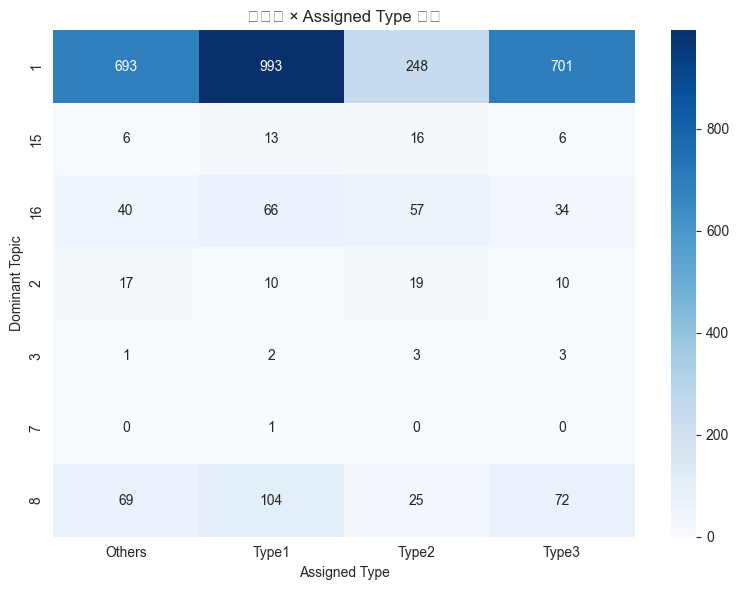

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(merged['dominant_topic'], merged['assigned_type'])
print(ct)

plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('주토픽 × Assigned Type 분포')
plt.ylabel('Dominant Topic')
plt.xlabel('Assigned Type')
plt.tight_layout()
plt.show()

assigned_type   Others  Type1  Type2  Type3
dominant_topic                             
0                    0      0      0      0
1                  693    993    248    701
2                   17     10     19     10
3                    1      2      3      3
4                    0      0      0      0
5                    0      0      0      0
6                    0      0      0      0
7                    0      1      0      0
8                   69    104     25     72
9                    0      0      0      0
10                   0      0      0      0
11                   0      0      0      0
12                   0      0      0      0
13                   0      0      0      0
14                   0      0      0      0
15                   6     13     16      6
16                  40     66     57     34
17                   0      0      0      0
18                   0      0      0      0
19                   0      0      0      0


/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/599864086.py:22: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/599864086.py:22: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/599864086.py:22: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/599864086.py:22: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/599864086.py:22: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/AI_news/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: User

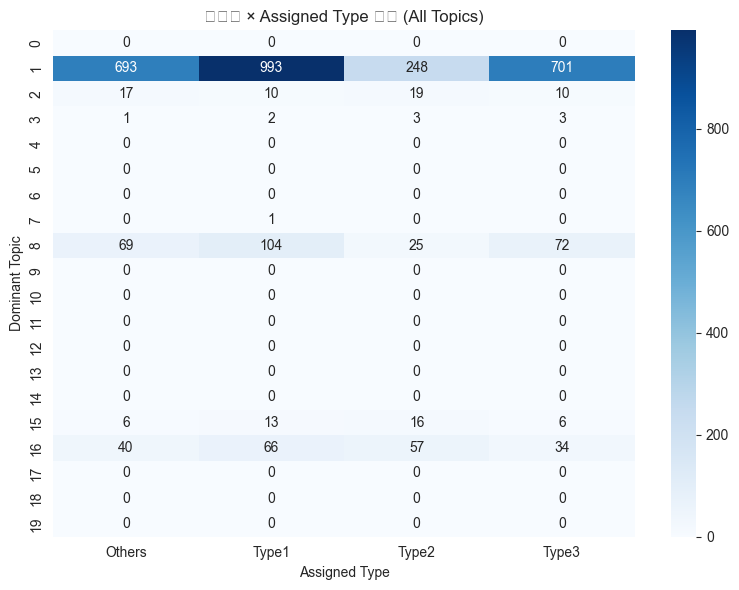

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 가능한 모든 토픽 레이블 리스트
all_topics = [f'{i}' for i in range(20)]

# 2) crosstab 생성
ct = pd.crosstab(merged['dominant_topic'], merged['assigned_type'])

# 3) 인덱스(토픽)를 all_topics로 재색인, 없는 건 0으로 채우기
ct = ct.reindex(index=all_topics, fill_value=0)

print(ct)

# 4) 히트맵 그리기
plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('주토픽 × Assigned Type 분포 (All Topics)')
plt.ylabel('Dominant Topic')
plt.xlabel('Assigned Type')
plt.tight_layout()
plt.show()

/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3610511664.py:6: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3610511664.py:6: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3610511664.py:6: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3610511664.py:6: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3610511664.py:6: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gb/6tdg7g8x441bp8yfgnfm4thh0000gn/T/ipykernel_46348/3610511664.py:6: UserWarni

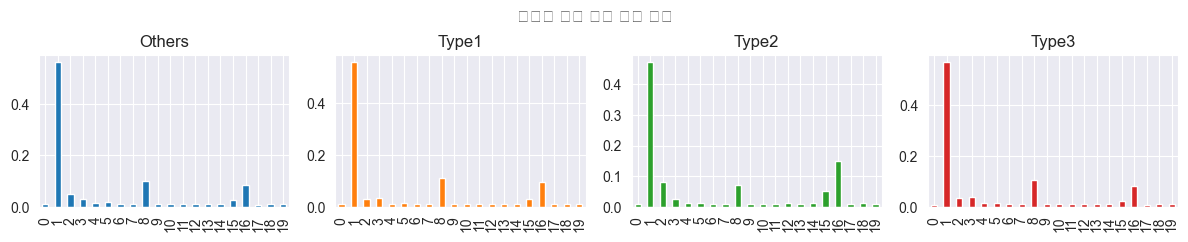

In [22]:
avg_topic = merged.groupby('assigned_type')[topic_cols].mean()

# avg_topic: 행=assigned_type, 열=topic_i
avg_topic.T.plot(kind='bar', subplots=True, layout=(5,4), figsize=(12,10), legend=False)
plt.suptitle('타입별 토픽 평균 확률 분포')
plt.tight_layout()
plt.show()

In [23]:
# gensim LdaModel 객체: lda_model
topic_terms = {
  tid: [w for w, _ in lda_model.show_topic(tid, topn=5)]
  for tid in range(lda_model.num_topics)
}

# 예: Type2 × topic_7 조합에서 상위 5개 문서
subset = merged[
  (merged['assigned_type']=='Type1') &
  (merged['dominant_topic']=='1')
].nlargest(5, '1')   # topic_1 기준
print(subset[['1','title','abstract','keywords']])

             1                                              title  \
1300  0.872059  Timely, Granular, and Actionable: Designing a ...   
2176  0.868826  Cognitive Load Theory Approach to Hybrid Intel...   
2459  0.867086  Designing Conversational Agents to Promote Env...   
1669  0.866282  Developing a Process Model for Digital Transfo...   
284   0.866139         The Design of an Ostensible Human Teammate   

                                               abstract  \
1300  Every day, patients access and generate online...   
2176  Knowledge workers in information-rich work env...   
2459  Conversational agents are increasingly integra...   
1669  The current volatile business environment has ...   
284   Reliance on computer-mediated teaming has expl...   

                                               keywords  
1300  public health 3.0, social listening, activity ...  
2176  Cognitive Load Theory, Augmented Intelligence,...  
2459  Conversational Agent, Environmental Sustainabi... 

# 4. 토픽모델링 결과 필터링 작업

In [1]:
import pandas as pd

df=pd.read_csv('data/03_journal_2023_2025_with_methods.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         3209 non-null   object
 1   date          3209 non-null   int64 
 2   abstract      3209 non-null   object
 3   keywords      3209 non-null   object
 4   authors       3209 non-null   object
 5   affiliations  3209 non-null   object
 6   methods       3209 non-null   object
dtypes: int64(1), object(6)
memory usage: 175.6+ KB


In [5]:
df['methods'][3204]

'The methodology used in this paper is a combination of the ontology developed from the C4MM and BPMN 2.0. The ontology is used to define the concepts and relationships within the C4MM, while BPMN 2.0 is used to represent the digital transformation journey of the construction organization in the form of a process model. The ontology is used to extract the research methodology of the paper in one concise line, and provide only the methodology without repeating the prompt.\n\nOntology: The ontology developed from the C4MM is a structured representation of the concepts and relationships within the model. It provides a clear and concise understanding of the concepts and their interrelationships, making it easier to analyze and interpret the data. The ontology is used to define the concepts and relationships within the C4MM, which is a framework for measuring the digital maturity of construction organizations. The ontology is used to extract the research methodology of the paper in one conc

## 4.1. 계획 수립
- journal topic modeling 결과로 나온 것 중에서 산업-학계 간 공통 토픽 3개 선정
- 3가지 주제 안에서 가장 수가 많은 토픽 1개 선정
- journal topic의 dominant topic으로 문서 필터링 진행
- methods에서 type 1,2,3 정의한 것 기준으로 type 1,2,3 분류

## 4.2. 전처리 필수 요건
- 행의 개수를 유지한 채로 토픽모델링 결과와 합쳐야 함
- 글자수 20글자 이하 행 제거: systematic review, this study is a ... <- 고민 좀 더 해보기
- 키워드에 researh, study, this, method, methodology, paper 이건 포함 X
- 중복 행 제거

## 4.3. 개수 파악

In [1]:
# dominant topic 1이 가장 많이 나오는게 문제임
import pandas as pd

# 1. CSV 파일 로드
df=pd.read_csv('data/industry_topic_distribution.csv')

# 2. 토픽 컬럼 이름 리스트 생성 (여기서는 '0'부터 '19'까지)
topic_cols = [str(i) for i in range(20)]

# 3. 각 행(row)마다 가장 확률이 높은 토픽을 찾아 'dominant_topic' 컬럼으로 추가
df['dominant_topic'] = df[topic_cols].idxmax(axis=1).astype(int)

# 4. 토픽별 문서 개수(count) 계산
topic_counts = df['dominant_topic'].value_counts().sort_index()

# 5. 결과 출력
print("토픽별 문서 수:")
for topic, count in topic_counts.items():
    print(f"토픽 {topic}: {count}개")

토픽별 문서 수:
토픽 1: 5개
토픽 2: 1개
토픽 7: 6개
토픽 9: 6개
토픽 12: 10450개
토픽 13: 12개
토픽 15: 31개
토픽 17: 1058개
토픽 18: 103개


In [18]:
import pandas as pd

def count_dominant_topics_excluding(
    csv_path: str,
    exclude_topics: list[int],
    num_topics: int = 20
) -> pd.Series:
    """
    CSV에서 지정한 토픽들을 제외한 나머지 토픽 중 dominant topic을 계산해 반환합니다.

    Parameters
    ----------
    csv_path : str
        확률 분포가 담긴 CSV 파일 경로.
    exclude_topics : list[int]
        제외할 토픽 번호 리스트 (예: [12, 5, 7]).
    num_topics : int
        전체 토픽 개수 (기본값 20).

    Returns
    -------
    pd.Series
        각 문서의 dominant_topic_excl 시리즈.
    """
    # 1. CSV 로드
    df = pd.read_csv(csv_path)

    # 2. 전체 토픽 컬럼 리스트 생성
    all_topics = [str(i) for i in range(num_topics)]

    # 3. 제외할 토픽 문자열 리스트
    exclude_strs = [str(t) for t in exclude_topics]

    # 4. 제외한 나머지 토픽 컬럼 리스트
    remaining_topics = [t for t in all_topics if t not in exclude_strs]

    # 5. dominant topic 계산
    df_excl = df[remaining_topics].copy()
    df_excl['dominant_topic_excl'] = df_excl.idxmax(axis=1).astype(int)

    return df_excl['dominant_topic_excl']


if __name__ == "__main__":
    # 파일 경로들
    topic_dist_path = 'data/industry_topic_distribution.csv'
    base_article_path = 'data/05_article_2023_2025.csv'
    output_path = 'data/05_article_merged_with_topic.csv'

    # 제외할 토픽
    exclude = [8, 12, 14, 16, 19]

    # dominant topic 계산
    dominant_series = count_dominant_topics_excluding(topic_dist_path, exclude)

    # 기존 기사 데이터 불러오기
    df_articles = pd.read_csv(base_article_path)

    # 데이터 길이 체크
    if len(df_articles) != len(dominant_series):
        raise ValueError("두 CSV의 행 수가 다릅니다. 병합 전 데이터 정렬 또는 인덱스 확인이 필요합니다.")

    # 병합 (인덱스 기준)
    df_articles['dominant_topic_excl'] = dominant_series.values

    # 저장
    df_articles.to_csv(output_path, index=False)

    # 콘솔 출력
    counts = dominant_series.value_counts().sort_index()
    print(f"토픽 {exclude} 제외 후 dominant topic별 문서 수:")
    for topic, cnt in counts.items():
        print(f"토픽 {topic}: {cnt}개")

토픽 [8, 12, 14, 16, 19] 제외 후 dominant topic별 문서 수:
토픽 0: 47개
토픽 1: 950개
토픽 2: 287개
토픽 3: 36개
토픽 4: 53개
토픽 5: 10개
토픽 6: 23개
토픽 7: 9개
토픽 9: 769개
토픽 10: 257개
토픽 11: 188개
토픽 13: 790개
토픽 15: 652개
토픽 17: 5801개
토픽 18: 1800개


# 5. type 분류
## 1. Media, Brand & social Effect 학계 토픽 2 type 분류 진행

### 전처리 진행 후 병합 데이터 저장 및 로드
- 20글자 이하 행 제거
- 데이터 합치기
- 중복 제거

In [17]:
import pandas as pd

# 1. CSV 파일 로드
dist_df    = pd.read_csv('data/academia_topic_distribution.csv')
methods_df = pd.read_csv('data/03_journal_2023_2025_with_methods.csv')

# 2. 데이터 합치기 (행 순서와 개수 유지)
df = pd.concat(
    [methods_df.reset_index(drop=True), dist_df.reset_index(drop=True)],
    axis=1
)

# 3. 전처리 작업
methods_col = 'methods'  # 실제 메소드 설명 컬럼명으로 수정하세요

# 3.1 글자수 20자 이하 행 제거
df = df[df[methods_col].str.len() > 20]

# 3.2 중복 행 제거
df = df.drop_duplicates(subset=[methods_col])

# 4. 저장
output_path = 'data/03_journal_2023_2025_with_methods_preprocessed.csv'
df.to_csv(output_path, index=False)

print(f"✔︎ Preprocessed data saved to {output_path} ({len(df)} rows)")

✔︎ Preprocessed data saved to data/03_journal_2023_2025_with_methods_preprocessed.csv (3186 rows)


In [18]:
test=pd.read_csv('data/03_journal_2023_2025_with_methods_preprocessed.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3186 non-null   object 
 1   date          3186 non-null   int64  
 2   abstract      3186 non-null   object 
 3   keywords      3186 non-null   object 
 4   authors       3186 non-null   object 
 5   affiliations  3186 non-null   object 
 6   methods       3186 non-null   object 
 7   doc_id        3186 non-null   int64  
 8   0             3186 non-null   float64
 9   1             3186 non-null   float64
 10  2             3186 non-null   float64
 11  3             3186 non-null   float64
 12  4             3186 non-null   float64
 13  5             3186 non-null   float64
 14  6             3186 non-null   float64
 15  7             3186 non-null   float64
 16  8             3186 non-null   float64
 17  9             3186 non-null   float64
 18  10            3186 non-null 

### 각 토픽 별로 type 분류 진행

In [1]:
import pandas as pd

def classify_and_save_topic_methods_by_count(
    preprocessed_path: str,
    target_topic: int,
    drop_topic: int = 1,
    methods_col: str = 'methods',
    output_dir: str = 'data'
):
    """
    전처리된 CSV에서 특정 토픽 문서만 골라,
    Type I–III 키워드 등장 횟수로 분류하고,
    매칭된 키워드를 함께 저장합니다.
    """
    # 1) 데이터 로드
    df = pd.read_csv(preprocessed_path)

    # 2) dominant_topic_excl_1 재계산 (drop_topic 제외)
    topic_cols      = [c for c in df.columns if c.isdigit()]
    topic_cols_excl = [c for c in topic_cols if int(c) != drop_topic]
    df['dominant_topic_excl_1'] = df[topic_cols_excl] \
        .idxmax(axis=1).astype(int)

    # 3) target_topic 필터링
    df_t = df[df['dominant_topic_excl_1'] == target_topic].copy()

    # ── Type I: ML Methods Development ──
    ml_terms = [
        "supervised learning", "unsupervised learning", "semi-supervised learning",
        "reinforcement learning", "transfer learning", "deep learning",
        "neural network", "cnn", "rnn", "lstm", "gru", "transformer",
        "attention mechanism", "bert", "gpt", "autoencoder", "gan",
        "decision tree", "random forest", "xgboost", "lightgbm", "adaboost",
        "gradient boosting", "gbm", "svm", "support vector machine",
        "knn", "k-nearest neighbors", "pca", "principal component analysis",
        "clustering", "k-means", "hierarchical clustering", "dbscan",
        "dropout", "batch normalization", "activation function","machine learning"
        "softmax", "ensemble", "stacking", "bagging", "algorithm", "design science","deep neural network","dnn","graph neural network","gnn","contrastive learning","self-supervised learning"
    ]

    # ── Type II: Understanding Phenomena using ML ──
    type2_terms = [
        "linear regression", "logistic regression", "ridge regression", "lasso",
        "tobit", "poisson regression", "negative binomial", "multinomial logistic regression",
        "difference-in-differences", "did", "propensity score", "propensity score matching",
        "instrumental variable", "treatment effect", "causal inference",
        "selection model", "heckman", "panel data", "panel var",
        "fixed effects", "random effects", "cointegration", "error correction model",
        "structural equation", "path analysis", "time series", "arima", "gmm",
        "survival analysis", "cox", "aic", "bic", "regression discontinuity","survey", "questionnaire", "case study","focus group", "grounded theory","ethnography",
        "content analysis", "thematic analysis"
    ]

    # ── Type III: ML in Complex Systems ──
    complex_terms = [
        "agent-based modeling", "agent-based simulation", "system dynamics",
        "monte carlo simulation", "cellular automata", "discrete event simulation",
        "scenario analysis", "network theory", "network analysis", "game theory",
        "markov decision process", "feedback loop", "emergent behavior",
        "complex systems", "multi-agent system", "stochastic simulation", "abm",
        "chaos theory", "fractal", "fuzzy logic", "petri net", "swarm intelligence",
        "cybernetics", "system identification",     "multi-scale modeling",
        "complex adaptive system","differential equations","network simulation",
        "network evolution","dynamic systems modeling","chaos modeling","genetic algorithm","evolutionary algorithm","particle swarm optimization","pso",
        "simulated annealing","ant colony optimization","control theory","feedback control","complex network analysis","community detection","percolation theory","small-world network","scale-free network",
    ]

    # ── (추가) 모든 키워드 리스트를 합쳐서 matched_keywords 생성
    all_terms = ml_terms + type2_terms + complex_terms
    def find_matched_keywords(txt: str) -> list:
        text = str(txt).lower()
        return [kw for kw in all_terms if kw in text]

    df_t['matched_keywords'] = df_t[methods_col].apply(find_matched_keywords)

    # ── 분류 함수: 각 리스트 등장 횟수 합산 후 최댓값 타입 반환, 모두 0이면 Type IV
    def classify_by_count(txt: str) -> int:
        text = str(txt).lower()
        counts = {
            1: sum(text.count(kw) for kw in ml_terms),
            2: sum(text.count(kw) for kw in type2_terms),
            3: sum(text.count(kw) for kw in complex_terms)
        }
        top_type, top_count = max(counts.items(), key=lambda x: x[1])
        return top_type if top_count > 0 else 4

    df_t['method_type'] = df_t[methods_col].apply(classify_by_count)

    # 결과 집계 출력
    counts = df_t['method_type'].value_counts().sort_index()
    print(f"▶️ Topic {target_topic} Method Type 분포 (Type I–IV):")
    for t, cnt in counts.items():
        print(f"   Type {t}: {cnt}개")

    # 파일로 저장 (matched_keywords 포함)
    out_path = f"{output_dir}/topic_{target_topic}_count_classified_I_IV_with_keywords.csv"
    df_t.to_csv(out_path, index=False)
    print(f"✔︎ Saved classified data (with keywords) to {out_path}")

    return counts

In [2]:
# ── 사용 예시 ──
preprocessed = 'data/03_journal_2023_2025_with_methods_preprocessed.csv'

# 토픽 2 count 기반 분류 및 저장
counts2 = classify_and_save_topic_methods_by_count(preprocessed, target_topic=2, output_dir='data/topic')

# 토픽 12
counts12 = classify_and_save_topic_methods_by_count(preprocessed, target_topic=12, output_dir='data/topic')

counts3 = classify_and_save_topic_methods_by_count(preprocessed, target_topic=3, output_dir='data/topic')

counts5 = classify_and_save_topic_methods_by_count(preprocessed, target_topic=5, output_dir='data/topic')

▶️ Topic 2 Method Type 분포 (Type I–IV):
   Type 1: 56개
   Type 2: 176개
   Type 3: 5개
   Type 4: 127개
✔︎ Saved classified data (with keywords) to data/topic/topic_2_count_classified_I_IV_with_keywords.csv
▶️ Topic 12 Method Type 분포 (Type I–IV):
   Type 1: 6개
   Type 2: 11개
   Type 4: 14개
✔︎ Saved classified data (with keywords) to data/topic/topic_12_count_classified_I_IV_with_keywords.csv
▶️ Topic 3 Method Type 분포 (Type I–IV):
   Type 1: 112개
   Type 2: 108개
   Type 3: 6개
   Type 4: 140개
✔︎ Saved classified data (with keywords) to data/topic/topic_3_count_classified_I_IV_with_keywords.csv
▶️ Topic 5 Method Type 분포 (Type I–IV):
   Type 1: 25개
   Type 2: 41개
   Type 4: 24개
✔︎ Saved classified data (with keywords) to data/topic/topic_5_count_classified_I_IV_with_keywords.csv


# 6. 키워드(내용) 확인

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

def suggest_ngrams_by_topic_from_title_abstract(
    df: pd.DataFrame,
    topic_num: int,
    topic_col: str = 'dominant_topic_excl',
    title_col: str = 'title',
    abstract_col: str = 'content',
    ngram_range: tuple = (3, 5),
    max_df: float = 0.8,
    min_df: int = 2,
    stop_words: str = 'english',
    max_features: int = 5000,
    top_n: int = 20
):
    """
    title + abstract 기반으로 특정 토픽(topic_num)에 해당하는 문서에서
    TF-IDF 기반 상위 n-gram 키워드를 추출합니다.

    Returns
    -------
    list[str]
        상위 n개의 n-gram 키워드 리스트
    """
    # 1) 특정 토픽 필터링
    df_sub = df[df[topic_col] == topic_num].copy()

    # 2) title과 abstract 결합
    df_sub['combined_text'] = (
        df_sub[title_col].fillna('') + ' ' + df_sub[abstract_col].fillna('')
    )

    corpus = df_sub['combined_text'].astype(str).tolist()
    if not corpus:
        return []

    # 3) TF-IDF 계산
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_df=max_df,
        min_df=min_df,
        stop_words=stop_words,
        max_features=max_features
    )
    X = vectorizer.fit_transform(corpus)

    # 4) 평균 TF-IDF 점수 계산
    mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
    features = vectorizer.get_feature_names_out()

    # 5) 상위 n개의 키워드 반환
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    return [features[i] for i in top_idx]

In [37]:
df = pd.read_csv("data/05_article_merged_with_topic.csv")
top_ngrams = suggest_ngrams_by_topic_from_title_abstract(df, topic_num=5, top_n=80)
print(top_ngrams)

['neural processing unit', 'cores low power', 'intel arc graphics', 'core ultra 200v', 'core ultra 200h', 'core ultra processor', 'core ultra 200u core', 'ultra 200u core', 'core ultra 200u', 'core ultra 200s', 'planting software components', 'year started selling', 'precision planting software components', 'precision planting software', 'core ultra 200v hx', '200s core ultra 200u', '200s core ultra 200u core', '200u core ultra', '200v hx chips', 'intel new core ultra', 'intel new core', 'core ultra 200v hx chips', 'new core ultra', 'ultra 200v hx', 'ultra 200v hx chips', 'core ultra 200u core ultra', 'ultra 200s core ultra', 'ultra 200u core ultra', 'core ultra 200s core ultra', 'core ultra 200s core', '200s core ultra', 'low power cores', 'ultra 200s core', 'ultra 200s core ultra 200u', 'deere year started selling', 'deere year started', 'ground upgrade cost 175', 'ground upgrade cost 175 000', 'hartsock vice president performance upgrades', 'harvesting combines crop', 'harvesting co

In [34]:
import pandas as pd

# 1. 데이터 로드
df = pd.read_csv('data/05_article_merged_with_topic.csv')  # 파일 경로에 맞게 수정

# 2. 소문자 통일 및 전처리 (선택적)
df['title'] = df['title'].astype(str).str.lower()  # 또는 'content' 컬럼 사용
df['content']=df['content'].astype(str).str.lower()

# 3. 'AI Act' 포함 및 dominant_topic == 1 조건 필터링
filtered_df = df[
    (df['dominant_topic_excl'] == 13) &
    (df['content'].str.contains('ambiant', case=False, na=False))
]

# 4. 결과 확인
print(filtered_df[['title', 'content','affiliations']].head(20))  # 또는 저장
# filtered_df.to_csv('ai_act_topic1.csv', index=False)

Empty DataFrame
Columns: [title, content, affiliations]
Index: []


In [33]:
filtered_df

,title,content,date,affiliations,keywords,dominant_topic_excl
116,apple unveils plans to bring ai to iphone --- ...,apple joined the artificial intelligence arms ...,2024.0,Wall Street Journal,NaN,13
226,bad year for cook keeps getting worse,"for tim cook, the hits keep coming.\non friday...",2025.0,Wall Street Journal,NaN,13
2443,‘hold on to your seats’: how much will ai affe...,"last year, rachel antell, an archival producer...",2024.0,the guardian,NaN,13
2543,how apple plans to usher in ‘new privacy stand...,"at its annual developers conference on monday,...",2024.0,the guardian,NaN,13
4423,samsung details ‘galaxy ai’ and a feature that...,samsung wants to make sure you know it cares a...,2023.0,verge,"AI, News, Samsung, Tech",13
5631,samsung’s s24 and s24 plus put new ai smarts i...,samsung’s galaxy s24 and s24 plus don’t have t...,2024.0,verge,"Mobile, News, Samsung, Tech",13
5701,the future of phones depends on the future of ...,"without looking up any leaks or rumors, i’d be...",2024.0,verge,Xiaomi is giving the currently China-exclusive...,13
5796,apple’s ai ambitions could include google or o...,apple is reportedly in “active negotiations” w...,2024.0,verge,"AI, Apple, iPhone, News, Tech",13
5864,apple’s new ai model hints at how ai could com...,apple has been quiet about its plans for gener...,2024.0,verge,"AI, Apple, News, Tech",13
6124,apple’s new accessibility features let you con...,applejust announceda slew of new accessibility...,2024.0,verge,"Apple, Creators, iPad, iPhone, News, Tech",13


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11672 entries, 0 to 11671
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                11672 non-null  object 
 1   content              11672 non-null  object 
 2   date                 11672 non-null  float64
 3   affiliations         11672 non-null  object 
 4   keywords             6252 non-null   object 
 5   dominant_topic_excl  11672 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 547.3+ KB


In [41]:
file=df[df['dominant_topic_excl']==13]
file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790 entries, 24 to 11642
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                790 non-null    object 
 1   content              790 non-null    object 
 2   date                 790 non-null    float64
 3   affiliations         790 non-null    object 
 4   keywords             469 non-null    object 
 5   dominant_topic_excl  790 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 43.2+ KB


In [43]:
file.to_excel('data/insight/industry_topic_13.xlsx', index=False)